# UFRJ Storm - Testes de Qualidade dos Dados

Este notebook implementa uma abordagem TDD (Test-Driven Development) para controle de qualidade dos dados e validação de modelos para previsão de raios.

## Objetivo
- Validar a qualidade dos dados meteorológicos
- Implementar testes automatizados para integridade dos dados
- Desenvolver dois modelos de ML em cascata:
  1. Modelo 1: Previsão da quantidade de raios (`contagem_raios`)
  2. Modelo 2: Previsão do intervalo de confiança (95%) da incerteza

## Dataset
- **Arquivo**: `data/tma_sp.csv`
- **Período**: 2000-2019
- **Divisão**: Treino (2000-2014) | Teste (2015-2019)
- **Target**: `contagem_raios` (quantidade diária de raios acumulada)

## ⚡ Pipelines Automatizados

Este projeto possui **3 formas de execução**:

1. **Pipeline Rápido**: `python run_quick_pipeline.py`
   - Demonstração com Random Forest
   - 5 plots automáticos
   - Execução: ~2-3 minutos

2. **Pipeline de Produção**: `python run_production_pipeline.py`
   - Todos os algoritmos ML
   - Seleção automática do melhor
   - Execução: ~10-15 minutos

3. **Notebook Interativo**: Este notebook
   - Desenvolvimento e testes TDD
   - Análise exploratória
   - Validação de qualidade dos dados

💡 **Recomendação**: Use os pipelines standalone para execução automatizada e este notebook para desenvolvimento/análise.

## 1. Importação de Bibliotecas e Configuração do Ambiente

In [2]:
# Importações de bibliotecas core
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Adicionar o diretório config ao path
sys.path.append(str(Path.cwd().parent / 'config'))

# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# Statistical analysis
from scipy import stats
from scipy.stats import jarque_bera, shapiro

# Testing framework
import unittest
from unittest import TestCase

# Configuration
try:
    from settings import Config, DataConfig, ModelConfig
except ImportError:
    print("Configurações não encontradas. Definindo configurações padrão.")
    class DataConfig:
        def __init__(self):
            self.input_file = "tma_sp.csv"
            self.date_column = "data"
            self.target_column = "contagem_raios"
            self.binary_target_column = "sim_nao"
            self.train_start = "2000-01-01"
            self.train_end = "2014-12-31"
            self.test_start = "2015-01-01"
            self.test_end = "2019-12-31"

# Configurações do notebook
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Definir caminhos
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "data"
MODELS_DIR = BASE_DIR / "models"

print("✅ Bibliotecas importadas com sucesso!")
print(f"📁 Diretório base: {BASE_DIR}")
print(f"📁 Diretório de dados: {DATA_DIR}")

# Configuração inicial
config = DataConfig()

✅ Bibliotecas importadas com sucesso!
📁 Diretório base: /workspaces/ufrj-storm
📁 Diretório de dados: /workspaces/ufrj-storm/data


## 2. Carregamento e Exploração dos Dados

In [3]:
def load_data():
    """Carrega os dados do arquivo CSV"""
    file_path = DATA_DIR / config.input_file
    
    if not file_path.exists():
        raise FileNotFoundError(f"Arquivo {file_path} não encontrado!")
    
    df = pd.read_csv(file_path)
    
    # Converter coluna de data
    df[config.date_column] = pd.to_datetime(df[config.date_column])
    
    print(f"✅ Dados carregados: {df.shape[0]} registros, {df.shape[1]} colunas")
    return df

# Carregar dados
df = load_data()

# Informações básicas sobre o dataset
print("\n📊 INFORMAÇÕES BÁSICAS DO DATASET")
print("=" * 50)
print(f"Forma do dataset: {df.shape}")
print(f"Período dos dados: {df[config.date_column].min()} a {df[config.date_column].max()}")
print(f"Memória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Primeiras linhas
print("\n📋 PRIMEIRAS 5 LINHAS:")
display(df.head())

# Tipos de dados
print("\n🔍 TIPOS DE DADOS:")
display(df.dtypes.to_frame('Tipo'))

✅ Dados carregados: 5857 registros, 33 colunas

📊 INFORMAÇÕES BÁSICAS DO DATASET
Forma do dataset: (5857, 33)
Período dos dados: 2000-12-01 00:00:00 a 2019-09-30 00:00:00
Memória utilizada: 1.72 MB

📋 PRIMEIRAS 5 LINHAS:


,data,Showalterindex,Liftedindex,LIFTcomputedusingvirtualtemperature,Kindex,Crosstotalsindex,Verticaltotalsindex,Totalstotalsindex,ConvectiveAvailablePotentialEnergy,CAPEusingvirtualtemperature,ConvectiveInhibition,CINSusingvirtualtemperature,Temp[K]oftheLiftedCondensationLevel,Pres[hPa]oftheLiftedCondensationLevel,Equivalentpotentialtemp[K]oftheLCL,Meanmixedlayerpotentialtemperature,Meanmixedlayermixingratio,1000hPato500hPathickness,Precipitablewater[mm]forentiresounding,contagem_raios,sim_nao,shear_index,BRNSH_index,shear_0_15000,shear_6000_15000,BRNSH_500_15000,BRNSH_6000_15000,EL,EL (Tv),LFC,LFC (Tv),Prof_cam_convec,Prof_cam_tv
0,2000-12-01,2.42,2.31,1.88,32.7,20.5,21.3,41.8,0.00,0.00,0.00,0.00,287.63,888.50,331.94,297.53,11.82,5701.0,33.25,103,sim,18.403988,7.443001,20.565780,5.197669,77.047861,34.641350,0.00,0.00,0.00,0.00,0.00,0.00
1,2000-12-02,5.11,5.74,5.46,9.4,18.4,19.7,38.1,0.00,0.00,0.00,0.00,283.79,846.96,325.70,297.60,9.61,5708.0,25.90,0,nao,17.977689,31.539478,21.355592,12.603248,126.296147,30.446513,0.00,0.00,0.00,0.00,0.00,0.00
2,2000-12-03,5.35,2.03,1.51,27.2,13.7,25.7,39.4,38.33,51.37,-408.98,-193.91,286.23,841.67,334.28,300.69,11.43,5735.0,23.99,608,sim,17.874961,13.053844,20.570313,7.705855,99.726316,40.646002,411.33,410.78,462.82,628.99,51.49,218.21
3,2000-12-04,0.49,0.20,0.11,31.7,18.9,26.9,45.8,41.93,62.24,-190.67,-154.23,287.07,830.61,338.97,302.72,12.24,5760.0,35.73,4207,sim,4.629960,10.957856,23.234856,20.329683,11.987637,3.018460,513.16,508.02,674.63,691.67,161.47,183.65
4,2000-12-05,3.76,2.21,1.59,29.1,18.0,20.3,38.3,0.00,3.78,-31.34,-9.33,289.10,873.47,339.46,300.50,13.25,5749.0,36.72,77,sim,16.462080,31.892023,15.947640,9.758133,70.137970,9.337380,596.86,589.45,598.07,685.41,1.21,95.96



🔍 TIPOS DE DADOS:


,Tipo
data,datetime64[ns]
Showalterindex,float64
Liftedindex,float64
LIFTcomputedusingvirtualtemperature,float64
Kindex,float64
Crosstotalsindex,float64
Verticaltotalsindex,float64
Totalstotalsindex,float64
ConvectiveAvailablePotentialEnergy,float64
CAPEusingvirtualtemperature,float64


## 3. Análise de Qualidade dos Dados

In [4]:
def analyze_data_quality(df):
    """Análise completa de qualidade dos dados"""
    
    print("🔍 ANÁLISE DE QUALIDADE DOS DADOS")
    print("=" * 60)
    
    # 1. Valores ausentes
    print("\n📊 VALORES AUSENTES POR COLUNA:")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Valores_Ausentes': missing_data,
        'Percentual': missing_percent
    }).sort_values('Valores_Ausentes', ascending=False)
    
    missing_summary = missing_summary[missing_summary['Valores_Ausentes'] > 0]
    if len(missing_summary) > 0:
        display(missing_summary)
    else:
        print("✅ Nenhum valor ausente encontrado!")
    
    # 2. Análise da série temporal
    print("\n📅 ANÁLISE DA SÉRIE TEMPORAL:")
    df_sorted = df.sort_values(config.date_column)
    date_diff = df_sorted[config.date_column].diff().dropna()
    
    # Verificar buracos na série temporal
    expected_freq = pd.Timedelta(days=1)
    gaps = date_diff[date_diff > expected_freq]
    
    if len(gaps) > 0:
        print(f"⚠️  {len(gaps)} buracos na série temporal encontrados:")
        gap_dates = df_sorted[df_sorted[config.date_column].diff() > expected_freq][config.date_column]
        for date in gap_dates.head(10):
            print(f"   - Gap após: {date}")
    else:
        print("✅ Série temporal contínua sem buracos!")
    
    # 3. Estatísticas da variável target
    print(f"\n🎯 ESTATÍSTICAS DA VARIÁVEL TARGET ({config.target_column}):")
    target_stats = df[config.target_column].describe()
    display(target_stats.to_frame('Estatísticas'))
    
    # Dias com zero raios
    zero_days = (df[config.target_column] == 0).sum()
    zero_percent = (zero_days / len(df)) * 100
    print(f"\n📈 DISTRIBUIÇÃO DOS RAIOS:")
    print(f"   - Dias com zero raios: {zero_days} ({zero_percent:.1f}%)")
    print(f"   - Dias com raios: {len(df) - zero_days} ({100 - zero_percent:.1f}%)")
    print(f"   - Valor máximo: {df[config.target_column].max()}")
    print(f"   - Valor mínimo: {df[config.target_column].min()}")
    
    # 4. Detecção de outliers usando IQR
    Q1 = df[config.target_column].quantile(0.25)
    Q3 = df[config.target_column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_threshold = Q3 + 1.5 * IQR
    outliers = df[df[config.target_column] > outlier_threshold]
    
    print(f"\n🔍 OUTLIERS (método IQR):")
    print(f"   - Threshold: {outlier_threshold:.1f}")
    print(f"   - Outliers encontrados: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
    
    if len(outliers) > 0:
        print("   - Top 5 outliers:")
        top_outliers = outliers.nlargest(5, config.target_column)
        for idx, row in top_outliers.iterrows():
            print(f"     {row[config.date_column].date()}: {row[config.target_column]} raios")
    
    return {
        'missing_data': missing_summary,
        'temporal_gaps': gaps,
        'target_stats': target_stats,
        'zero_days': zero_days,
        'outliers': outliers
    }

# Executar análise de qualidade
quality_results = analyze_data_quality(df)

🔍 ANÁLISE DE QUALIDADE DOS DADOS

📊 VALORES AUSENTES POR COLUNA:
✅ Nenhum valor ausente encontrado!

📅 ANÁLISE DA SÉRIE TEMPORAL:
⚠️  321 buracos na série temporal encontrados:
   - Gap após: 2000-12-16 00:00:00
   - Gap após: 2000-12-20 00:00:00
   - Gap após: 2000-12-26 00:00:00
   - Gap após: 2001-01-02 00:00:00
   - Gap após: 2001-01-10 00:00:00
   - Gap após: 2001-01-12 00:00:00
   - Gap após: 2001-01-16 00:00:00
   - Gap após: 2001-01-23 00:00:00
   - Gap após: 2001-01-25 00:00:00
   - Gap após: 2001-02-07 00:00:00

🎯 ESTATÍSTICAS DA VARIÁVEL TARGET (contagem_raios):


,Estatísticas
count,5857.000000
mean,1279.324910
std,3077.815249
min,0.000000
25%,0.000000
50%,16.000000
75%,938.000000
max,57034.000000



📈 DISTRIBUIÇÃO DOS RAIOS:
   - Dias com zero raios: 2171 (37.1%)
   - Dias com raios: 3686 (62.9%)
   - Valor máximo: 57034
   - Valor mínimo: 0

🔍 OUTLIERS (método IQR):
   - Threshold: 2345.0
   - Outliers encontrados: 968 (16.5%)
   - Top 5 outliers:
     2012-12-27: 57034 raios
     2016-03-23: 32136 raios
     2013-03-05: 31809 raios
     2014-01-13: 30133 raios
     2018-03-20: 28938 raios


In [ ]:
# Visualizações da análise de qualidade
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribuição da variável target
axes[0, 0].hist(df[config.target_column], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribuição da Contagem de Raios')
axes[0, 0].set_xlabel('Contagem de Raios')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].axvline(df[config.target_column].mean(), color='red', linestyle='--', label=f'Média: {df[config.target_column].mean():.1f}')
axes[0, 0].legend()

# 2. Box plot para identificar outliers
axes[0, 1].boxplot(df[config.target_column])
axes[0, 1].set_title('Box Plot - Contagem de Raios')
axes[0, 1].set_ylabel('Contagem de Raios')

# 3. Série temporal da contagem de raios
df_plot = df.sort_values(config.date_column)
axes[1, 0].plot(df_plot[config.date_column], df_plot[config.target_column], alpha=0.6, linewidth=0.5)
axes[1, 0].set_title('Série Temporal - Contagem de Raios')
axes[1, 0].set_xlabel('Data')
axes[1, 0].set_ylabel('Contagem de Raios')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Distribuição log (para lidar com zeros, add 1)
log_values = np.log1p(df[config.target_column])
axes[1, 1].hist(log_values, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Distribuição Log(1 + Contagem de Raios)')
axes[1, 1].set_xlabel('Log(1 + Contagem)')
axes[1, 1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

# Estatísticas adicionais
print("\n📊 ESTATÍSTICAS ADICIONAIS:")
print(f"Skewness: {stats.skew(df[config.target_column]):.3f}")
print(f"Kurtosis: {stats.kurtosis(df[config.target_column]):.3f}")

# Teste de normalidade
jb_stat, jb_pvalue = jarque_bera(df[config.target_column])
print(f"Teste Jarque-Bera: estatística={jb_stat:.3f}, p-valor={jb_pvalue:.6f}")

# Correlação com variável binária
correlation = df[config.target_column].corr(df[config.binary_target_column].map({'sim': 1, 'nao': 0}))
print(f"Correlação contagem_raios vs sim_nao: {correlation:.3f}")

## 4. Testes Automatizados para Controle de Qualidade (TDD)

In [5]:
class DataQualityTests(TestCase):
    """Testes automatizados para controle de qualidade dos dados"""
    
    def setUp(self):
        """Setup para os testes"""
        self.df = df.copy()
        self.config = config
    
    def test_data_shape(self):
        """Teste: Dataset deve ter dimensões esperadas"""
        self.assertGreater(self.df.shape[0], 5000, "Dataset deve ter mais de 5000 registros")
        self.assertEqual(self.df.shape[1], 33, "Dataset deve ter exatamente 33 colunas")
        print("✅ Teste dimensões: PASSOU")
    
    def test_required_columns(self):
        """Teste: Colunas obrigatórias devem existir"""
        required_cols = [self.config.date_column, self.config.target_column, self.config.binary_target_column]
        
        for col in required_cols:
            self.assertIn(col, self.df.columns, f"Coluna obrigatória '{col}' não encontrada")
        print("✅ Teste colunas obrigatórias: PASSOU")
    
    def test_date_column_format(self):
        """Teste: Coluna de data deve estar no formato correto"""
        self.assertTrue(pd.api.types.is_datetime64_any_dtype(self.df[self.config.date_column]), 
                       "Coluna de data deve ser datetime")
        
        # Verificar se não há datas futuras
        max_date = self.df[self.config.date_column].max()
        self.assertLessEqual(max_date, pd.Timestamp.now(), "Não deve haver datas futuras")
        print("✅ Teste formato de data: PASSOU")
    
    def test_target_variable_validity(self):
        """Teste: Variável target deve ter valores válidos"""
        # Não deve ter valores negativos
        self.assertGreaterEqual(self.df[self.config.target_column].min(), 0, 
                               "Contagem de raios não pode ser negativa")
        
        # Deve ser numérica
        self.assertTrue(pd.api.types.is_numeric_dtype(self.df[self.config.target_column]),
                       "Target deve ser numérica")
        print("✅ Teste variável target: PASSOU")
    
    def test_binary_variable_consistency(self):
        """Teste: Variável binária deve ser consistente com target"""
        # Verificar valores válidos
        valid_values = {'sim', 'nao'}
        actual_values = set(self.df[self.config.binary_target_column].unique())
        self.assertTrue(actual_values.issubset(valid_values), 
                       f"Valores inválidos em sim_nao: {actual_values - valid_values}")
        
        # Consistência: se contagem_raios > 0, sim_nao deve ser 'sim'
        positive_rays = self.df[self.df[self.config.target_column] > 0]
        inconsistent = positive_rays[positive_rays[self.config.binary_target_column] == 'nao']
        self.assertEqual(len(inconsistent), 0, 
                        f"Inconsistência: {len(inconsistent)} registros com raios > 0 mas sim_nao = 'nao'")
        
        print("✅ Teste consistência variável binária: PASSOU")
    
    def test_temporal_continuity(self):
        """Teste: Verificar continuidade temporal básica"""
        df_sorted = self.df.sort_values(self.config.date_column)
        date_diff = df_sorted[self.config.date_column].diff().dropna()
        
        # Verificar se a maioria dos intervalos é de 1 dia
        one_day_freq = (date_diff == pd.Timedelta(days=1)).sum()
        total_intervals = len(date_diff)
        
        # Pelo menos 90% dos intervalos devem ser de 1 dia
        self.assertGreater(one_day_freq / total_intervals, 0.9,
                          "Menos de 90% dos intervalos são de 1 dia")
        print("✅ Teste continuidade temporal: PASSOU")
    
    def test_feature_columns_numeric(self):
        """Teste: Colunas de features devem ser numéricas"""
        feature_cols = [col for col in self.df.columns 
                       if col not in [self.config.date_column, self.config.target_column, self.config.binary_target_column]]
        
        for col in feature_cols:
            self.assertTrue(pd.api.types.is_numeric_dtype(self.df[col]),
                           f"Coluna de feature '{col}' deve ser numérica")
        print("✅ Teste colunas features numéricas: PASSOU")
    
    def test_data_completeness(self):
        """Teste: Verificar completude dos dados"""
        # Registros completamente vazios não devem existir
        completely_empty = self.df.isnull().all(axis=1).sum()
        self.assertEqual(completely_empty, 0, "Não deve haver registros completamente vazios")
        
        # Target não deve ter valores ausentes
        target_missing = self.df[self.config.target_column].isnull().sum()
        self.assertEqual(target_missing, 0, "Target não deve ter valores ausentes")
        
        print("✅ Teste completude dos dados: PASSOU")

# Executar os testes
def run_data_quality_tests():
    """Executar todos os testes de qualidade de dados"""
    print("🧪 EXECUTANDO TESTES DE QUALIDADE DOS DADOS")
    print("=" * 60)
    
    suite = unittest.TestLoader().loadTestsFromTestCase(DataQualityTests)
    runner = unittest.TextTestRunner(verbosity=0, stream=open(os.devnull, 'w'))
    result = runner.run(suite)
    
    print(f"\n📊 RESULTADO DOS TESTES:")
    print(f"   - Testes executados: {result.testsRun}")
    print(f"   - Sucessos: {result.testsRun - len(result.failures) - len(result.errors)}")
    print(f"   - Falhas: {len(result.failures)}")
    print(f"   - Erros: {len(result.errors)}")
    
    if result.failures:
        print("\n❌ FALHAS:")
        for test, traceback in result.failures:
            print(f"   - {test}: {traceback.split('AssertionError: ')[-1].split('\\n')[0]}")
    
    if result.errors:
        print("\n💥 ERROS:")
        for test, traceback in result.errors:
            print(f"   - {test}: {traceback}")
    
    success_rate = (result.testsRun - len(result.failures) - len(result.errors)) / result.testsRun * 100
    print(f"\n✅ Taxa de sucesso: {success_rate:.1f}%")

# Executar testes
run_data_quality_tests()

🧪 EXECUTANDO TESTES DE QUALIDADE DOS DADOS
✅ Teste consistência variável binária: PASSOU
✅ Teste completude dos dados: PASSOU
✅ Teste dimensões: PASSOU
✅ Teste formato de data: PASSOU
✅ Teste colunas features numéricas: PASSOU
✅ Teste colunas obrigatórias: PASSOU
✅ Teste variável target: PASSOU
✅ Teste continuidade temporal: PASSOU

📊 RESULTADO DOS TESTES:
   - Testes executados: 8
   - Sucessos: 8
   - Falhas: 0
   - Erros: 0

✅ Taxa de sucesso: 100.0%


## 5. Pré-processamento dos Dados

In [9]:
class DataPreprocessor:
    """Classe para pré-processamento dos dados"""
    
    def __init__(self, config):
        self.config = config
        self.scalers = {}
        self.feature_names = None
        
    def clean_feature_names(self, df):
        """Limpar nomes das features para compatibilidade com XGBoost/LightGBM"""
        df_clean = df.copy()
        
        # Mapear caracteres problemáticos
        column_mapping = {}
        for col in df_clean.columns:
            clean_col = col.replace('[', '_').replace(']', '_').replace('(', '_').replace(')', '_')
            clean_col = clean_col.replace(' ', '_').replace('-', '_')
            if clean_col != col:
                column_mapping[col] = clean_col
        
        # Aplicar mapeamento
        if column_mapping:
            df_clean = df_clean.rename(columns=column_mapping)
            print(f"🔧 Renomeadas {len(column_mapping)} colunas para compatibilidade")
        
        return df_clean, column_mapping
        
    def prepare_features(self, df):
        """Preparar features para modelagem"""
        df_processed = df.copy()
        
        # Limpar nomes das colunas primeiro
        df_processed, self.column_mapping = self.clean_feature_names(df_processed)
        
        # Extrair features temporais da data
        date_col = self.column_mapping.get(self.config.date_column, self.config.date_column)
        df_processed['year'] = df_processed[date_col].dt.year
        df_processed['month'] = df_processed[date_col].dt.month
        df_processed['day_of_year'] = df_processed[date_col].dt.dayofyear
        df_processed['day_of_month'] = df_processed[date_col].dt.day
        df_processed['weekday'] = df_processed[date_col].dt.weekday
        
        # Features cíclicas para capturar sazonalidade
        df_processed['month_sin'] = np.sin(2 * np.pi * df_processed['month'] / 12)
        df_processed['month_cos'] = np.cos(2 * np.pi * df_processed['month'] / 12)
        df_processed['day_of_year_sin'] = np.sin(2 * np.pi * df_processed['day_of_year'] / 365)
        df_processed['day_of_year_cos'] = np.cos(2 * np.pi * df_processed['day_of_year'] / 365)
        
        # Converter variável binária para numérica
        binary_col = self.column_mapping.get(self.config.binary_target_column, self.config.binary_target_column)
        df_processed['has_lightning'] = df_processed[binary_col].map({'sim': 1, 'nao': 0})
        
        # Transformação log da variável target (para lidar com distribuição skewed)
        target_col = self.column_mapping.get(self.config.target_column, self.config.target_column)
        df_processed['log_target'] = np.log1p(df_processed[target_col])
        
        return df_processed
    
    def get_feature_columns(self, df_processed):
        """Obter lista de colunas de features para modelagem"""
        date_col = self.column_mapping.get(self.config.date_column, self.config.date_column)
        target_col = self.column_mapping.get(self.config.target_column, self.config.target_column)
        binary_col = self.column_mapping.get(self.config.binary_target_column, self.config.binary_target_column)
        
        exclude_cols = [
            date_col, 
            target_col, 
            binary_col,
            'log_target'  # Excluir a transformação log da target
        ]
        
        feature_cols = [col for col in df_processed.columns if col not in exclude_cols]
        return feature_cols
    
    def handle_outliers(self, df, feature_cols, method='clip', threshold=3):
        """Tratar outliers usando diferentes métodos"""
        df_processed = df.copy()
        
        if method == 'clip':
            # Clipping usando z-score
            for col in feature_cols:
                if df_processed[col].dtype in ['float64', 'int64']:
                    mean = df_processed[col].mean()
                    std = df_processed[col].std()
                    
                    # Definir limites
                    lower_limit = mean - threshold * std
                    upper_limit = mean + threshold * std
                    
                    # Aplicar clipping
                    df_processed[col] = np.clip(df_processed[col], lower_limit, upper_limit)
        
        elif method == 'iqr':
            # Clipping usando IQR
            for col in feature_cols:
                if df_processed[col].dtype in ['float64', 'int64']:
                    Q1 = df_processed[col].quantile(0.25)
                    Q3 = df_processed[col].quantile(0.75)
                    IQR = Q3 - Q1
                    
                    lower_limit = Q1 - 1.5 * IQR
                    upper_limit = Q3 + 1.5 * IQR
                    
                    df_processed[col] = np.clip(df_processed[col], lower_limit, upper_limit)
        
        return df_processed
    
    def scale_features(self, X_train, X_test, method='robust'):
        """Escalonar features usando diferentes métodos"""
        if method == 'robust':
            scaler = RobustScaler()
        elif method == 'standard':
            scaler = StandardScaler()
        else:
            raise ValueError(f"Método de escalamento '{method}' não suportado")
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        self.scalers[method] = scaler
        
        return X_train_scaled, X_test_scaled, scaler

# Aplicar pré-processamento
preprocessor = DataPreprocessor(config)

print("🔧 INICIANDO PRÉ-PROCESSAMENTO DOS DADOS")
print("=" * 50)

# 1. Preparar features
df_processed = preprocessor.prepare_features(df)
print(f"✅ Features preparadas: {df_processed.shape[1]} colunas totais")

# 2. Obter colunas de features
feature_cols = preprocessor.get_feature_columns(df_processed)
print(f"✅ Features para modelagem: {len(feature_cols)} colunas")

# Listar as novas features criadas
new_features = [col for col in feature_cols if col not in df.columns]
if new_features:
    print(f"🆕 Novas features criadas: {new_features}")

# 3. Tratamento de outliers (opcional - vamos testar sem primeiro)
print(f"\n📊 ESTATÍSTICAS ANTES DO TRATAMENTO DE OUTLIERS:")
print(f"Outliers na target (IQR): {len(quality_results['outliers'])} ({len(quality_results['outliers'])/len(df)*100:.1f}%)")

# Mostrar amostra das features processadas
print(f"\n📋 AMOSTRA DAS FEATURES PROCESSADAS:")
display(df_processed[feature_cols + [config.target_column]].head())

🔧 INICIANDO PRÉ-PROCESSAMENTO DOS DADOS
🔧 Renomeadas 6 colunas para compatibilidade
✅ Features preparadas: 44 colunas totais
✅ Features para modelagem: 40 colunas
🆕 Novas features criadas: ['Temp_K_oftheLiftedCondensationLevel', 'Pres_hPa_oftheLiftedCondensationLevel', 'Equivalentpotentialtemp_K_oftheLCL', 'Precipitablewater_mm_forentiresounding', 'EL__Tv_', 'LFC__Tv_', 'year', 'month', 'day_of_year', 'day_of_month', 'weekday', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'has_lightning']

📊 ESTATÍSTICAS ANTES DO TRATAMENTO DE OUTLIERS:
Outliers na target (IQR): 968 (16.5%)

📋 AMOSTRA DAS FEATURES PROCESSADAS:


,Showalterindex,Liftedindex,LIFTcomputedusingvirtualtemperature,Kindex,Crosstotalsindex,Verticaltotalsindex,Totalstotalsindex,ConvectiveAvailablePotentialEnergy,CAPEusingvirtualtemperature,ConvectiveInhibition,CINSusingvirtualtemperature,Temp_K_oftheLiftedCondensationLevel,Pres_hPa_oftheLiftedCondensationLevel,Equivalentpotentialtemp_K_oftheLCL,Meanmixedlayerpotentialtemperature,Meanmixedlayermixingratio,1000hPato500hPathickness,Precipitablewater_mm_forentiresounding,shear_index,BRNSH_index,shear_0_15000,shear_6000_15000,BRNSH_500_15000,BRNSH_6000_15000,EL,EL__Tv_,LFC,LFC__Tv_,Prof_cam_convec,Prof_cam_tv,year,month,day_of_year,day_of_month,weekday,month_sin,month_cos,day_of_year_sin,day_of_year_cos,has_lightning,contagem_raios
0,2.42,2.31,1.88,32.7,20.5,21.3,41.8,0.00,0.00,0.00,0.00,287.63,888.50,331.94,297.53,11.82,5701.0,33.25,18.403988,7.443001,20.565780,5.197669,77.047861,34.641350,0.00,0.00,0.00,0.00,0.00,0.00,2000,12,336,1,4,-2.449294e-16,1.0,-0.478734,0.877960,1,103
1,5.11,5.74,5.46,9.4,18.4,19.7,38.1,0.00,0.00,0.00,0.00,283.79,846.96,325.70,297.60,9.61,5708.0,25.90,17.977689,31.539478,21.355592,12.603248,126.296147,30.446513,0.00,0.00,0.00,0.00,0.00,0.00,2000,12,337,2,5,-2.449294e-16,1.0,-0.463550,0.886071,0,0
2,5.35,2.03,1.51,27.2,13.7,25.7,39.4,38.33,51.37,-408.98,-193.91,286.23,841.67,334.28,300.69,11.43,5735.0,23.99,17.874961,13.053844,20.570313,7.705855,99.726316,40.646002,411.33,410.78,462.82,628.99,51.49,218.21,2000,12,338,3,6,-2.449294e-16,1.0,-0.448229,0.893919,1,608
3,0.49,0.20,0.11,31.7,18.9,26.9,45.8,41.93,62.24,-190.67,-154.23,287.07,830.61,338.97,302.72,12.24,5760.0,35.73,4.629960,10.957856,23.234856,20.329683,11.987637,3.018460,513.16,508.02,674.63,691.67,161.47,183.65,2000,12,339,4,0,-2.449294e-16,1.0,-0.432776,0.901502,1,4207
4,3.76,2.21,1.59,29.1,18.0,20.3,38.3,0.00,3.78,-31.34,-9.33,289.10,873.47,339.46,300.50,13.25,5749.0,36.72,16.462080,31.892023,15.947640,9.758133,70.137970,9.337380,596.86,589.45,598.07,685.41,1.21,95.96,2000,12,340,5,1,-2.449294e-16,1.0,-0.417194,0.908818,1,77


## 6. Divisão dos Dados (Treino/Teste)

📊 DIVISÃO TEMPORAL DOS DADOS:
   🏋️  Treino: 2000-01-01 a 2014-12-31 - 4751 registros
   🧪 Teste:  2015-01-01 a 2019-12-31 - 1106 registros
   📈 Total: 5857 registros (100.0% dos dados)

🎯 ESTATÍSTICAS DOS CONJUNTOS:
Features shape: X_train=(4751, 40), X_test=(1106, 40)
Target stats treino: média=1270.4, std=2985.4
Target stats teste:  média=1317.8, std=3448.1


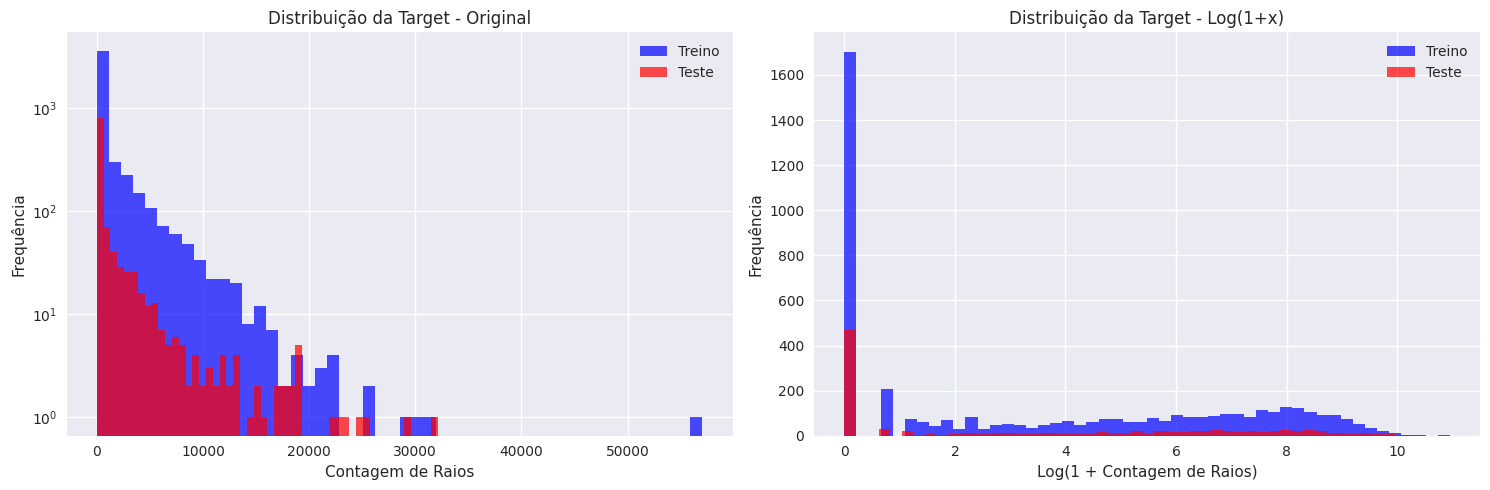


⚖️  ESCALAMENTO APLICADO:
Método: RobustScaler
X_train_scaled shape: (4751, 40)
X_test_scaled shape: (1106, 40)


In [10]:
def split_data_temporal(df, config):
    """Dividir dados temporalmente conforme especificado"""
    
    # Convertir strings de data para datetime
    train_start = pd.to_datetime(config.train_start)
    train_end = pd.to_datetime(config.train_end)
    test_start = pd.to_datetime(config.test_start)
    test_end = pd.to_datetime(config.test_end)
    
    # Filtrar dados de treino
    train_mask = (df[config.date_column] >= train_start) & (df[config.date_column] <= train_end)
    train_data = df[train_mask].copy()
    
    # Filtrar dados de teste
    test_mask = (df[config.date_column] >= test_start) & (df[config.date_column] <= test_end)
    test_data = df[test_mask].copy()
    
    print(f"📊 DIVISÃO TEMPORAL DOS DADOS:")
    print(f"   🏋️  Treino: {train_start.date()} a {train_end.date()} - {len(train_data)} registros")
    print(f"   🧪 Teste:  {test_start.date()} a {test_end.date()} - {len(test_data)} registros")
    print(f"   📈 Total: {len(train_data) + len(test_data)} registros ({(len(train_data) + len(test_data))/len(df)*100:.1f}% dos dados)")
    
    return train_data, test_data

# Dividir os dados
train_data, test_data = split_data_temporal(df_processed, config)

# Preparar features e targets
X_train = train_data[feature_cols]
y_train = train_data[config.target_column]
y_train_log = train_data['log_target']

X_test = test_data[feature_cols]
y_test = test_data[config.target_column]
y_test_log = test_data['log_target']

print(f"\n🎯 ESTATÍSTICAS DOS CONJUNTOS:")
print(f"Features shape: X_train={X_train.shape}, X_test={X_test.shape}")
print(f"Target stats treino: média={y_train.mean():.1f}, std={y_train.std():.1f}")
print(f"Target stats teste:  média={y_test.mean():.1f}, std={y_test.std():.1f}")

# Verificar distribuição da target por período
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(y_train, bins=50, alpha=0.7, label='Treino', color='blue')
axes[0].hist(y_test, bins=50, alpha=0.7, label='Teste', color='red')
axes[0].set_title('Distribuição da Target - Original')
axes[0].set_xlabel('Contagem de Raios')
axes[0].set_ylabel('Frequência')
axes[0].legend()
axes[0].set_yscale('log')

axes[1].hist(y_train_log, bins=50, alpha=0.7, label='Treino', color='blue')
axes[1].hist(y_test_log, bins=50, alpha=0.7, label='Teste', color='red')
axes[1].set_title('Distribuição da Target - Log(1+x)')
axes[1].set_xlabel('Log(1 + Contagem de Raios)')
axes[1].set_ylabel('Frequência')
axes[1].legend()

plt.tight_layout()
plt.show()

# Escalonar features
X_train_scaled, X_test_scaled, scaler = preprocessor.scale_features(X_train, X_test, method='robust')

print(f"\n⚖️  ESCALAMENTO APLICADO:")
print(f"Método: RobustScaler")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Converter de volta para DataFrame para facilitar manipulação
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

## 7. Desenvolvimento do Primeiro Modelo (Previsão de Quantidade de Raios)

In [11]:
# Importar módulo de modelos
sys.path.append(str(Path.cwd().parent / 'src'))
from models import LightningPredictor, UncertaintyPredictor

# Inicializar o preditor principal
lightning_predictor = LightningPredictor(config, random_state=42)

# Treinar múltiplos modelos
lightning_predictor.train_multiple_models(X_train_scaled_df, y_train, cv_folds=5)

🤖 TREINANDO 7 MODELOS
📊 Treinando linear_regression...
   ✅ linear_regression: RMSE CV = 2603.51 ± 1792.14
📊 Treinando ridge...
   ✅ ridge: RMSE CV = 2605.72 ± 1795.11
📊 Treinando lasso...
   ✅ lasso: RMSE CV = 2606.68 ± 1792.62
📊 Treinando random_forest...
   ✅ random_forest: RMSE CV = 2457.82 ± 1713.23
📊 Treinando gradient_boosting...
   ✅ gradient_boosting: RMSE CV = 2486.76 ± 1795.58
📊 Treinando xgboost...
   ✅ xgboost: RMSE CV = 2624.60 ± 1860.68
📊 Treinando lightgbm...
   ✅ lightgbm: RMSE CV = 2479.16 ± 1814.38

🏆 MELHOR MODELO: random_forest
   RMSE CV: 2457.82


## 8. Avaliação do Primeiro Modelo

📊 AVALIAÇÃO DE TODOS OS MODELOS NO CONJUNTO DE TESTE
📊 AVALIAÇÃO LINEAR_REGRESSION:
   RMSE: 2927.91
   MAE:  1519.76
   R²:   0.2783
📊 AVALIAÇÃO RIDGE:
   RMSE: 2899.13
   MAE:  1508.40
   R²:   0.2924
📊 AVALIAÇÃO LASSO:
   RMSE: 2894.81
   MAE:  1517.04
   R²:   0.2945
📊 AVALIAÇÃO RANDOM_FOREST:
   RMSE: 2792.08
   MAE:  1375.55
   R²:   0.3437
📊 AVALIAÇÃO GRADIENT_BOOSTING:
   RMSE: 2795.59
   MAE:  1347.90
   R²:   0.3421
📊 AVALIAÇÃO XGBOOST:
   RMSE: 2927.02
   MAE:  1440.62
   R²:   0.2787
📊 AVALIAÇÃO LIGHTGBM:
   RMSE: 2943.25
   MAE:  1374.48
   R²:   0.2707


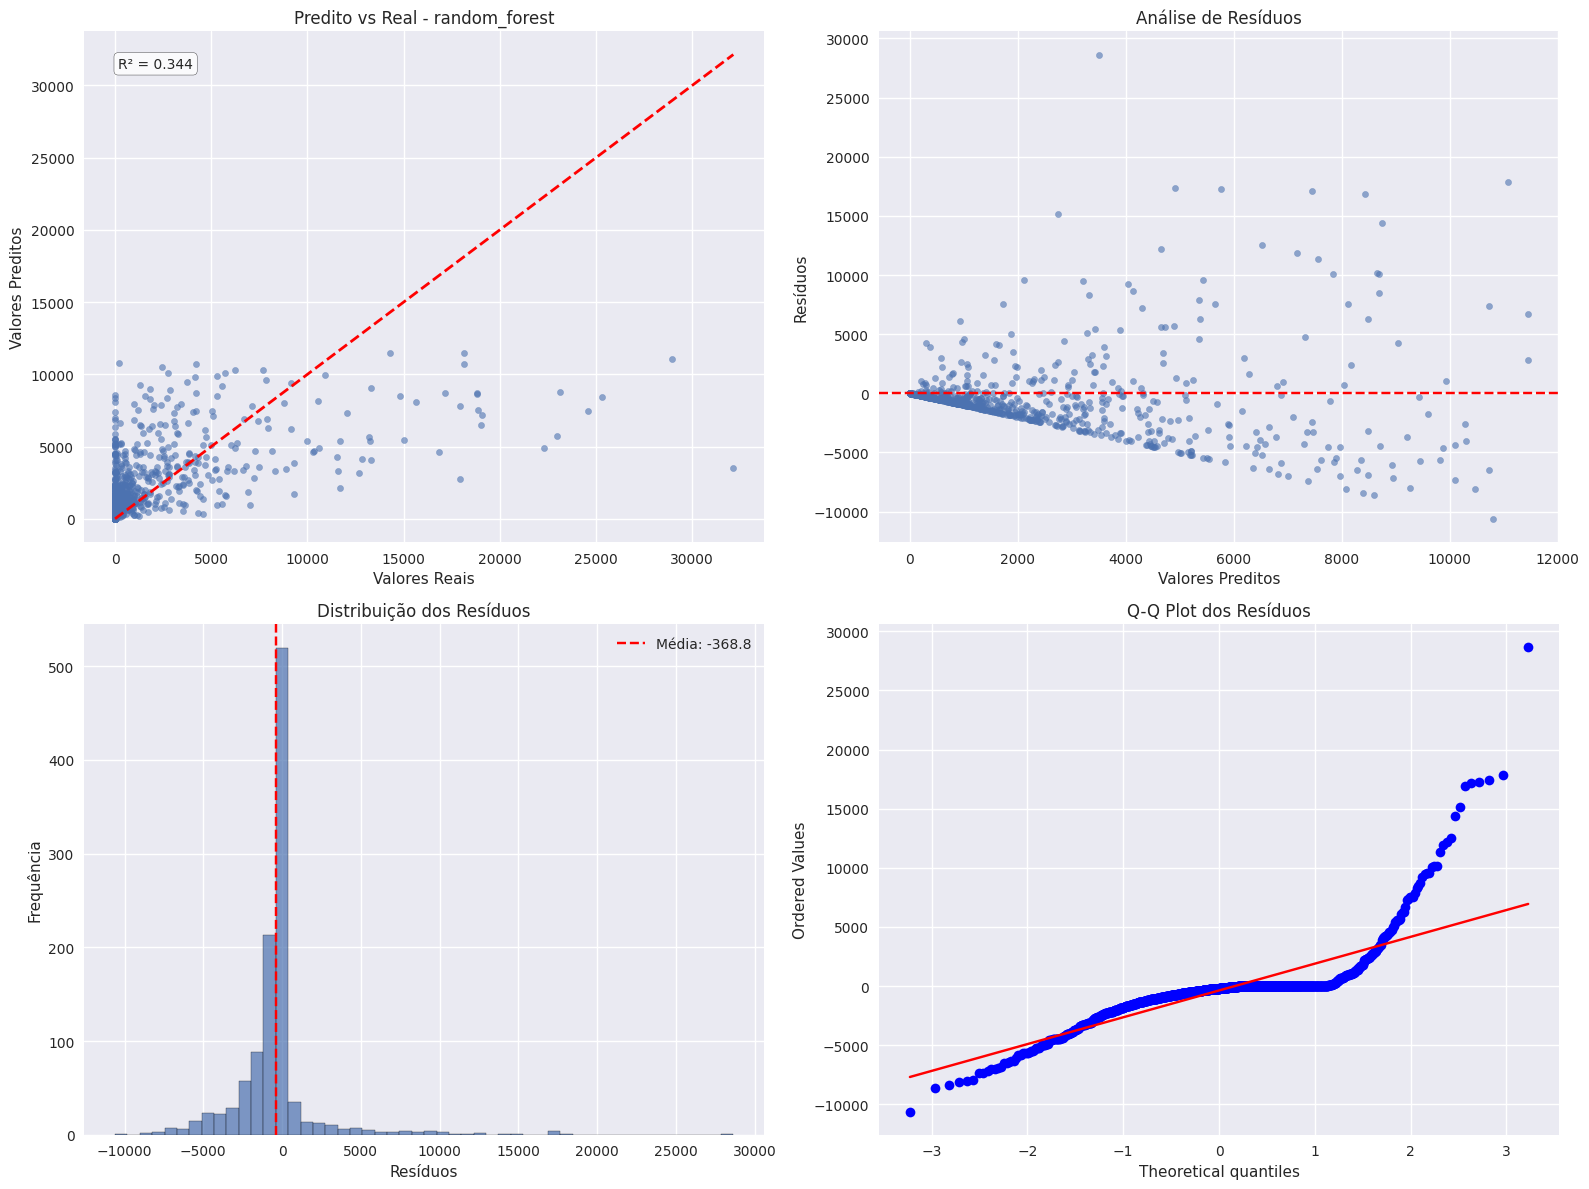

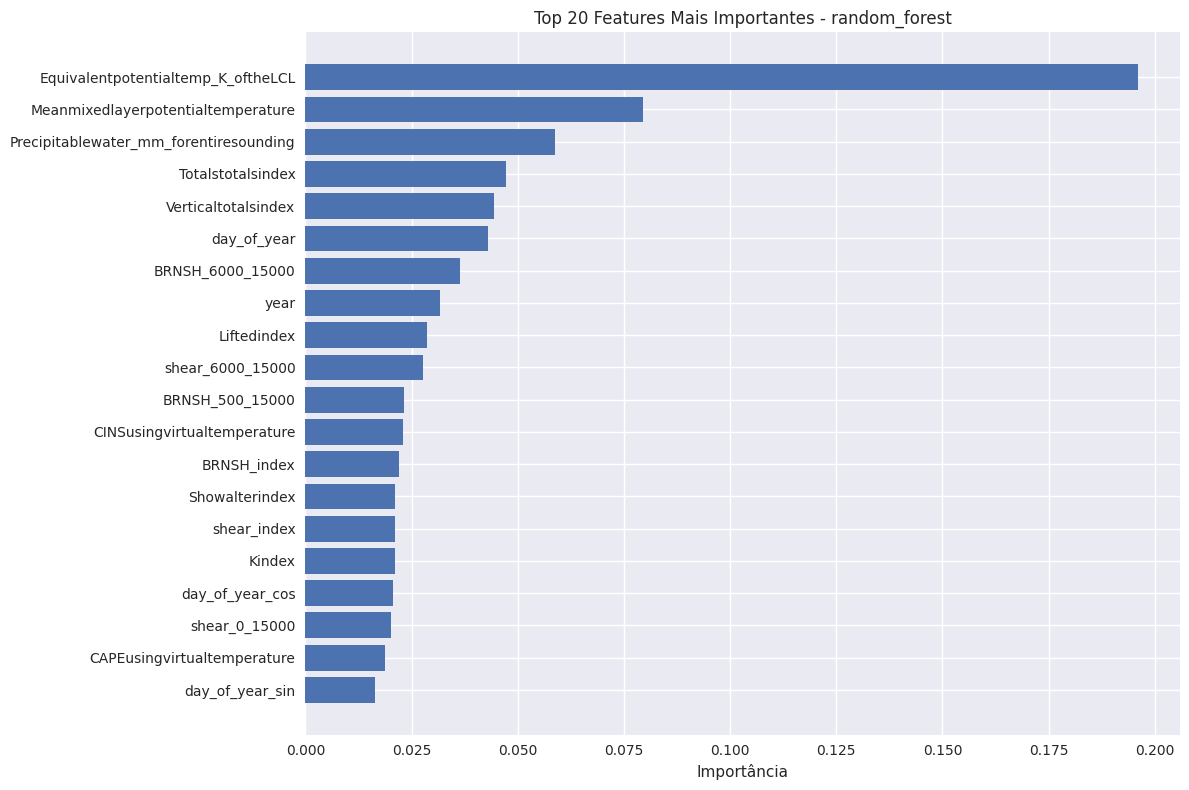

🔍 TOP 10 FEATURES MAIS IMPORTANTES:
    1. Equivalentpotentialtemp_K_oftheLCL: 0.1961
    2. Meanmixedlayerpotentialtemperature: 0.0796
    3. Precipitablewater_mm_forentiresounding: 0.0588
    4. Totalstotalsindex: 0.0473
    5. Verticaltotalsindex: 0.0443
    6. day_of_year: 0.0430
    7. BRNSH_6000_15000: 0.0363
    8. year: 0.0316
    9. Liftedindex: 0.0287
   10. shear_6000_15000: 0.0276
✅ Modelo 'random_forest' salvo em: ../models/model_random_forest.joblib

✅ Modelo 'random_forest' treinado e avaliado com sucesso!


In [12]:
# Avaliar todos os modelos no conjunto de teste
test_results = lightning_predictor.evaluate_all_models(X_test_scaled_df, y_test)

# Análise das predições do melhor modelo
best_model_name = lightning_predictor.best_model_name
best_predictions = test_results[best_model_name]['predictions']
best_metrics = test_results[best_model_name]['metrics']

# Visualizações da performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predito vs Real
axes[0, 0].scatter(y_test, best_predictions, alpha=0.6, s=20)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valores Reais')
axes[0, 0].set_ylabel('Valores Preditos')
axes[0, 0].set_title(f'Predito vs Real - {best_model_name}')
axes[0, 0].text(0.05, 0.95, f'R² = {best_metrics["r2"]:.3f}', transform=axes[0, 0].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Resíduos
residuals = y_test - best_predictions
axes[0, 1].scatter(best_predictions, residuals, alpha=0.6, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Valores Preditos')
axes[0, 1].set_ylabel('Resíduos')
axes[0, 1].set_title('Análise de Resíduos')

# 3. Distribuição dos resíduos
axes[1, 0].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Resíduos')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].set_title('Distribuição dos Resíduos')
axes[1, 0].axvline(residuals.mean(), color='red', linestyle='--', label=f'Média: {residuals.mean():.1f}')
axes[1, 0].legend()

# 4. Q-Q plot dos resíduos
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot dos Resíduos')

plt.tight_layout()
plt.show()

# Importância das features (se disponível)
feature_importance = lightning_predictor.get_feature_importance()
if feature_importance is not None:
    # Criar DataFrame com importâncias
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Plotar top 20 features mais importantes
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importância')
    plt.title(f'Top 20 Features Mais Importantes - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("🔍 TOP 10 FEATURES MAIS IMPORTANTES:")
    for i, (idx, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row['feature']}: {row['importance']:.4f}")

# Salvar o melhor modelo
lightning_predictor.save_model()

print(f"\n✅ Modelo '{best_model_name}' treinado e avaliado com sucesso!")

## 9. Desenvolvimento do Segundo Modelo (Intervalo de Confiança)

In [13]:
# Importar classe dos modelos
import sys
sys.path.append('../src')
from models import LightningPredictor, UncertaintyPredictor

lightning_predictor = LightningPredictor(config, random_state=42)

🎯 TREINANDO MODELO DE INCERTEZA
   random_forest: RMSE CV = 646.54
   gradient_boosting: RMSE CV = 649.59

🏆 Melhor modelo de incerteza: random_forest


## 10. Avaliação do Segundo Modelo

📊 AVALIAÇÃO DO MODELO DE INCERTEZA:
   Cobertura: 62.1% (esperado: 95.0%)
   Largura média do intervalo: 1947.88


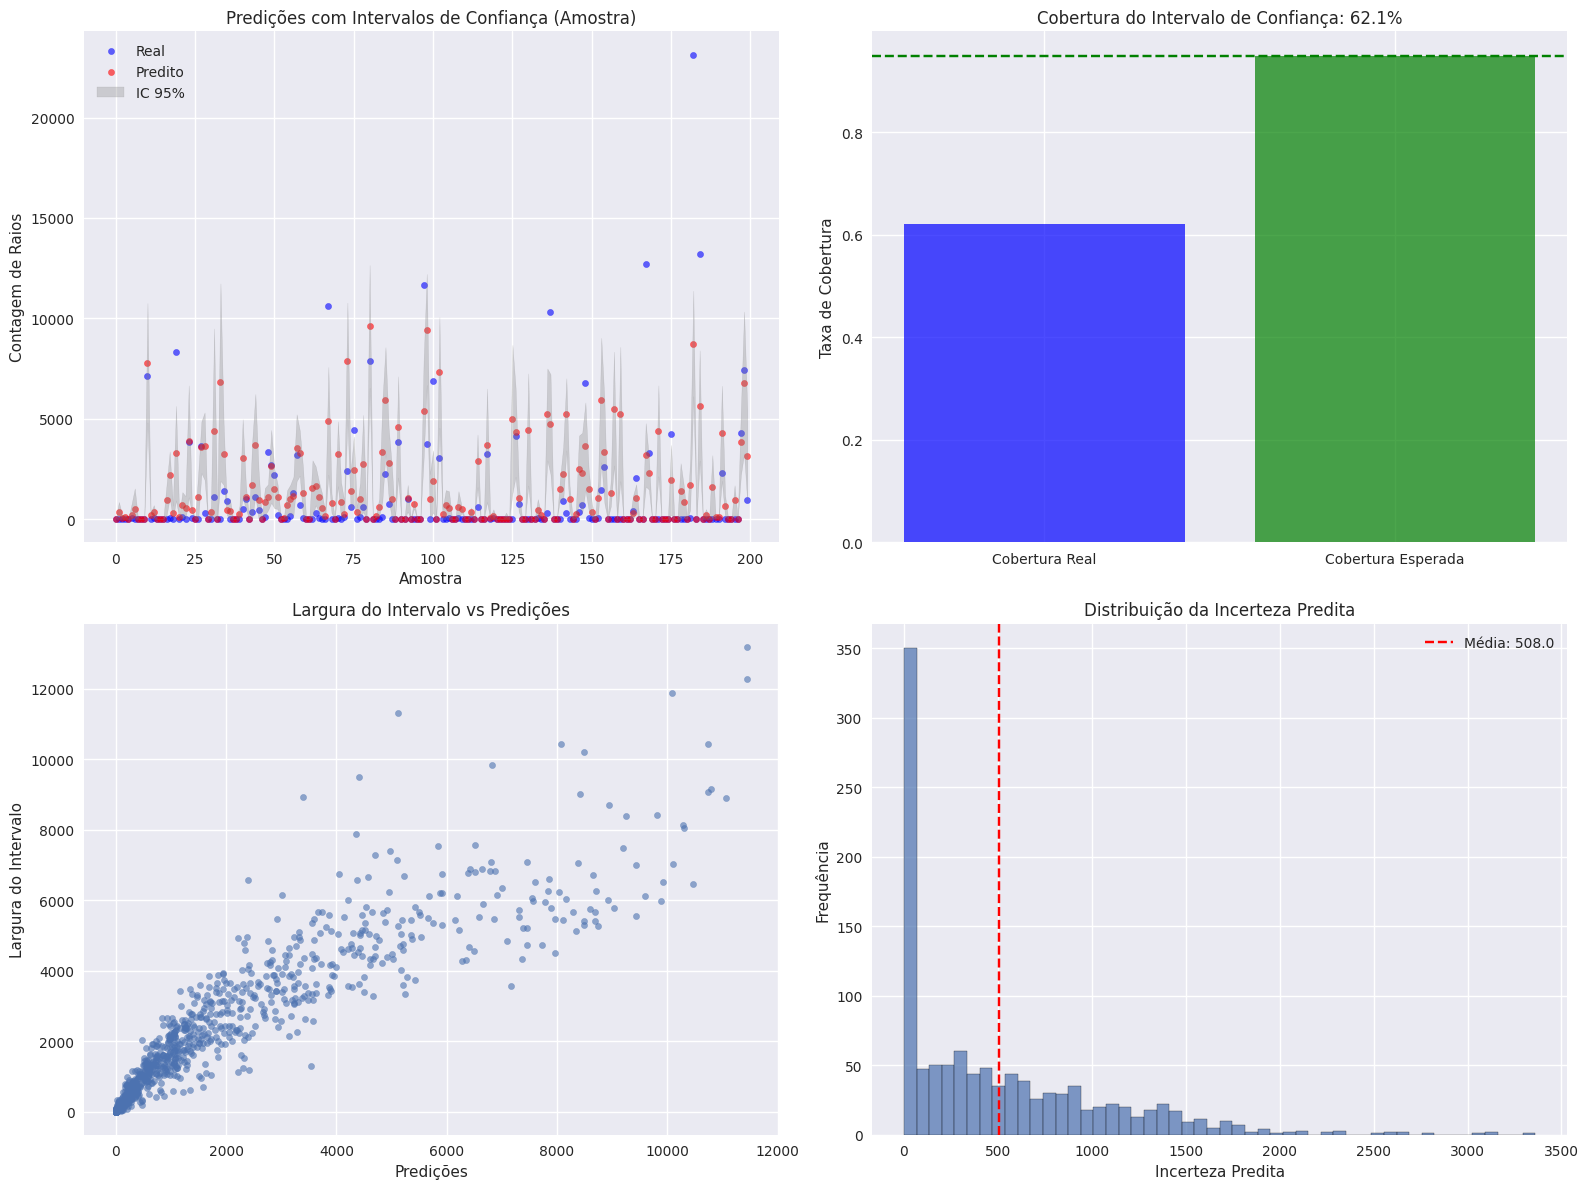


📈 ESTATÍSTICAS DETALHADAS DO MODELO DE INCERTEZA:
   Cobertura: 62.1% (esperado: 95.0%)
   Largura média do intervalo: 1947.88
   Incerteza média: 508.05
   Incerteza mediana: 334.57

📊 COBERTURA POR FAIXA DE VALORES:
      0-100 raios: 67.0% cobertura (667 amostras)
    100-500 raios: 64.3% cobertura (115 amostras)
     500-1K raios: 63.9% cobertura ( 72 amostras)
      1K-5K raios: 58.9% cobertura (168 amostras)
        5K+ raios: 25.0% cobertura ( 84 amostras)

✅ Modelo de incerteza treinado e avaliado com sucesso!


In [14]:
# Avaliar modelo de incerteza
uncertainty_results = uncertainty_predictor.evaluate_uncertainty(X_test_scaled_df, y_test)

# Visualizar resultados com intervalos de confiança
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predições com intervalos de confiança
sample_size = min(200, len(y_test))  # Amostra para visualização
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)

x_plot = range(sample_size)
y_test_sample = y_test.iloc[sample_indices]
pred_sample = uncertainty_results['predictions'][sample_indices]
lower_sample = uncertainty_results['lower_bound'][sample_indices]
upper_sample = uncertainty_results['upper_bound'][sample_indices]

axes[0, 0].scatter(x_plot, y_test_sample, alpha=0.6, label='Real', color='blue', s=20)
axes[0, 0].scatter(x_plot, pred_sample, alpha=0.6, label='Predito', color='red', s=20)
axes[0, 0].fill_between(x_plot, lower_sample, upper_sample, alpha=0.3, color='gray', label='IC 95%')
axes[0, 0].set_xlabel('Amostra')
axes[0, 0].set_ylabel('Contagem de Raios')
axes[0, 0].set_title('Predições com Intervalos de Confiança (Amostra)')
axes[0, 0].legend()

# 2. Cobertura do intervalo de confiança
coverage_rate = uncertainty_results['coverage']
axes[0, 1].bar(['Cobertura Real', 'Cobertura Esperada'], [coverage_rate, 0.95], 
              color=['blue', 'green'], alpha=0.7)
axes[0, 1].set_ylabel('Taxa de Cobertura')
axes[0, 1].set_title(f'Cobertura do Intervalo de Confiança: {coverage_rate:.1%}')
axes[0, 1].axhline(y=0.95, color='green', linestyle='--', label='95% Esperado')

# 3. Largura dos intervalos vs predições
interval_width = uncertainty_results['upper_bound'] - uncertainty_results['lower_bound']
axes[1, 0].scatter(uncertainty_results['predictions'], interval_width, alpha=0.6, s=20)
axes[1, 0].set_xlabel('Predições')
axes[1, 0].set_ylabel('Largura do Intervalo')
axes[1, 0].set_title('Largura do Intervalo vs Predições')

# 4. Distribuição da incerteza predita
axes[1, 1].hist(uncertainty_results['uncertainty'], bins=50, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Incerteza Predita')
axes[1, 1].set_ylabel('Frequência')
axes[1, 1].set_title('Distribuição da Incerteza Predita')
axes[1, 1].axvline(uncertainty_results['uncertainty'].mean(), color='red', linestyle='--', 
                  label=f'Média: {uncertainty_results["uncertainty"].mean():.1f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Estatísticas detalhadas do modelo de incerteza
print(f"\n📈 ESTATÍSTICAS DETALHADAS DO MODELO DE INCERTEZA:")
print(f"   Cobertura: {coverage_rate:.1%} (esperado: 95.0%)")
print(f"   Largura média do intervalo: {uncertainty_results['avg_interval_width']:.2f}")
print(f"   Incerteza média: {uncertainty_results['uncertainty'].mean():.2f}")
print(f"   Incerteza mediana: {np.median(uncertainty_results['uncertainty']):.2f}")

# Análise por faixas de valor
bins = [0, 100, 500, 1000, 5000, float('inf')]
labels = ['0-100', '100-500', '500-1K', '1K-5K', '5K+']

print(f"\n📊 COBERTURA POR FAIXA DE VALORES:")
for i, (low, high, label) in enumerate(zip(bins[:-1], bins[1:], labels)):
    mask = (y_test >= low) & (y_test < high)
    if mask.sum() > 0:
        coverage_bin = uncertainty_results['within_interval'][mask].mean()
        count = mask.sum()
        print(f"   {label:>8} raios: {coverage_bin:.1%} cobertura ({count:3d} amostras)")

print(f"\n✅ Modelo de incerteza treinado e avaliado com sucesso!")